<a href="https://colab.research.google.com/github/Samruddhi-saoji/Deep-Learning-self-study-codes/blob/main/Hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras-tuner

Image classification on cifar10 dataset with Hyperparameter tuning

In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

Prepare data

In [ ]:
# import dataset
from tensorflow.keras.datasets import cifar10

# Train test split
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

# feature scaling
X_train, X_test = X_train / 255.0, X_test / 255.0

170498071/170498071 [==============================] - 3s 0us/step


In [ ]:
e = 2 #training epochs

# Hyperactive tuning using Random Search technique

## Define model building function

In [ ]:
# argument hp will be passed by the tuner
def build_model(hp):
    model = Sequential()

    # add layers
    model.add(Conv2D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=(3, 3),
        activation='relu',
        input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        activation='relu'))
    model.add(Dense(10, activation='softmax'))

    # compile model
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model

## Create tuner object

In [ ]:
# Create tuner object
tuner = kt.RandomSearch(
    build_model, #function to build model
    objective='val_accuracy',
    max_trials=2,
    executions_per_trial=2,
    directory='my_dir',
    project_name='cifar10_tuning')

Reloading Tuner from my_dir/cifar10_tuning/tuner0.json


## Do the Tuning

In [ ]:
# do the tuning
tuner.search(X_train, Y_train, epochs=e, validation_split=0.2)

# find the best set of hp
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 6 Complete [00h 06m 48s]
val_accuracy: 0.5900000035762787

Best val_accuracy So Far: 0.6037999987602234
Total elapsed time: 00h 25m 18s


# Training

## Create the model with the best hp values

In [ ]:
# create the model with the best hyperparams
model = tuner.hypermodel.build(best_hp)

## Train the model

In [ ]:
# Training and validation
train_info = model.fit(X_train, Y_train, epochs=e, validation_split=0.2)

Epoch 1/2
1250/1250 [==============================] - 45s 35ms/step - loss: 1.4548 - accuracy: 0.4791 - val_loss: 1.2499 - val_accuracy: 0.5659
Epoch 2/2
1250/1250 [==============================] - 45s 36ms/step - loss: 1.1528 - accuracy: 0.5957 - val_loss: 1.2046 - val_accuracy: 0.5785


## Plot loss over epochs

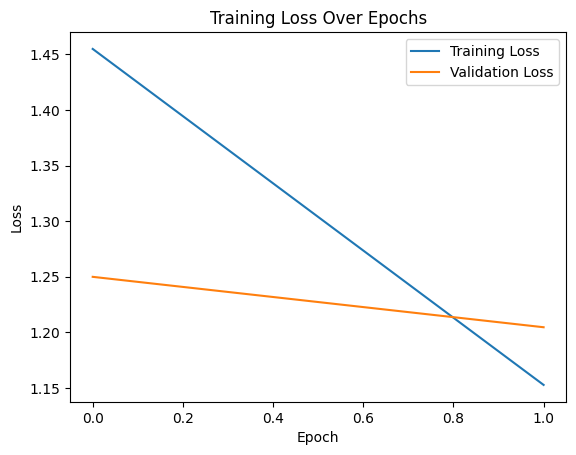

In [ ]:
#plot the loss over the epochs
plt.plot(train_info.history['loss'], label='Training Loss')
plt.plot(train_info.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Testing

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test accuracy:{test_accuracy:.4f}")

313/313 [==============================] - 3s 8ms/step - loss: 1.1911 - accuracy: 0.5740
Test accuracy:0.5740
